# Music Genre Classification
In this project, I have implemented a music genre classification system using the GTZAN dataset. The GTZAN dataset consists of 1000 audio tracks each 30 seconds long. It contains 10 genres, each represented by 100 tracks. The tracks are all 22050Hz Mono 16-bit audio files in .wav format. 

### Instructions to run the code


1. Download the GTZAN dataset from the following link: https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification
2. Extract the dataset and place it in the 'Data' folder in the same directory as the notebook.
3. Run the code cells in the notebook to extract features from raw audio files and train the models.
4. The code cells are divided into two parts: Feature Extraction from Scratch and Feature Extraction Using Pre-trained VGGish Model.
5. The Feature Extraction from Scratch part extracts features from raw audio files and trains the models using LSTM, CNN, and Transformer architectures.
6. The Feature Extraction Using Pre-trained VGGish Model part extracts features using the pre-trained VGGish model and trains the models using LSTM, CNN, and Transformer architectures.
7. The results of the models are displayed at the end of each part.


### Installing and Importing Required Libraries

In [1]:
!pip install -q visualkeras
!pip install librosa

In [2]:
!pip install tensorflow_hub
!pip install tensorflow

In [4]:
# Data preprocessing
import pandas as pd
import numpy as np
import os, librosa
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Visualization
import IPython.display as ipd
import matplotlib.pyplot as plt
import seaborn as sns
from visualkeras import layered_view

# Model
import tensorflow_hub as hub
from tensorflow import keras
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras import layers, Sequential
from keras.callbacks import EarlyStopping
import librosa.display

# Suppressing warnings
from warnings import filterwarnings
filterwarnings('ignore')

### Data Preprocessing and Visualization

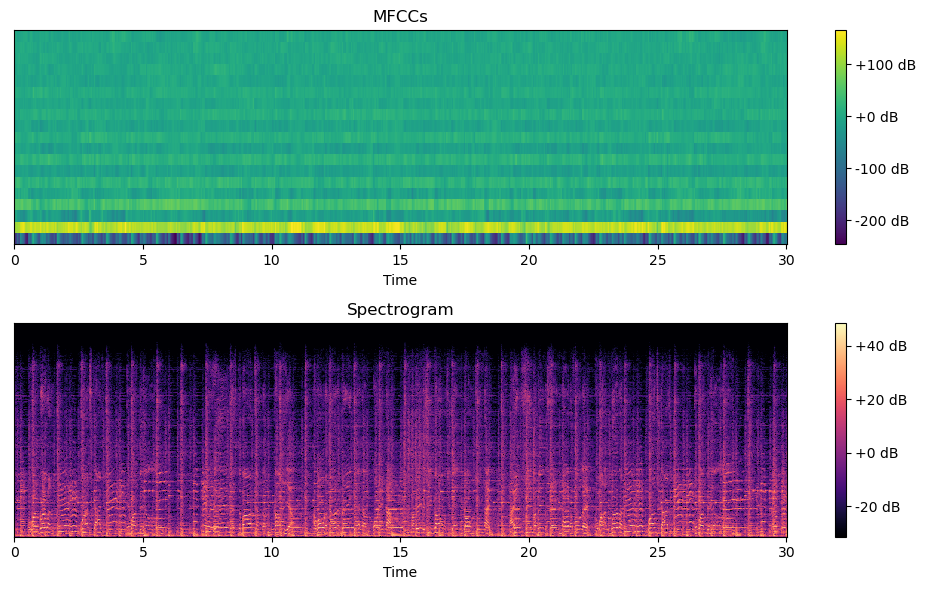

In [17]:
# The dataset consists of 1000 audio tracks each 30 seconds long. It contains 10 genres, each represented by 100 tracks.
# The tracks are all 22050Hz Mono 16-bit audio files in .wav format.
# Since the dataset mentions that the audio files are sampled at 22050Hz, it means that each second of audio contains 22,050 amplitude samples.
# The audio files are mono, which means there is only one channel of audio data.
# The files are 16-bit, which means that each amplitude sample is quantized to an integer value between -32,768 and 32,767.

# Set the path to your Gtzan dataset directory
gtzan_dir = "./Data/genres_original"

# In the context of audio processing, y typically represents the raw audio signal itself, which is a one-dimensional array (or vector) of amplitude values over time.
# Each value in the y array corresponds to the amplitude of the audio signal at a specific point in time. The amplitude represents the air pressure fluctuations that our ears interpret as sound.
# y variable will be a one-dimensional NumPy array with 22050 * 30 = 661,500 elements.
# Load an audio file
file_path = os.path.join(gtzan_dir, "blues/blues.00000.wav")
y, sr = librosa.load(file_path, sr=None)

# This rescales the entire signal such that the maximum value (positive or negative) is now 1, while maintaining the relative proportions of the other values.
# Normalize the audio signal
y_normalized = y / np.max(np.abs(y))

# Compute MFCCs
# The librosa.feature.mfcc function takes three main arguments:
# y: The audio time series (the y_normalized array in your case, which is the normalized audio signal).
# sr: The sampling rate of the audio signal (in Hz).
# n_mfcc: The number of MFCC coefficients to return.

# This value of 19 is a common choice for many audio processing tasks, as it has been found to capture most of the relevant information in the spectral envelope.(ref?)
# Increasing the value of n_mfcc will result in more MFCC coefficients being computed. This means that the MFCC representation will capture more detailed information about the spectral envelope of the audio signal.
# Decreasing the value of n_mfcc will result in fewer MFCC coefficients being computed. This means that the MFCC representation will capture a more coarse or smoothed representation of the spectral envelope.
n_mfcc = 19
mfccs = librosa.feature.mfcc(y=y_normalized, sr=sr, n_mfcc=n_mfcc)


#computes the spectrogram of the audio signal y_normalized by:

# Calculating the Short-Time Fourier Transform (STFT) of the signal, which provides the Fourier coefficients for each time frame.
# Taking the absolute value of the complex-valued STFT output to obtain the magnitudes (amplitudes) of the Fourier coefficients.
# Squaring the magnitudes to represent the energy or power distribution across different frequencies over time, which is the spectrogram.

# The resulting spectrogram variable will be a 2D NumPy array, where the rows represent different frequencies,
# the columns represent different time frames, and the values in the array represent the energy or power of the signal at each time-frequency bin.'''

# Compute spectrogram
spectrogram = np.abs(librosa.stft(y_normalized))**2

# Visualize MFCCs and spectrogram
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
librosa.display.specshow(mfccs, x_axis="time", sr=sr, cmap="viridis")
plt.colorbar(format="%+2.0f dB")
plt.title("MFCCs")
plt.subplot(2, 1, 2)
librosa.display.specshow(librosa.power_to_db(spectrogram), x_axis="time", sr=sr, cmap="magma")
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram")
plt.tight_layout()
plt.show()

### Data Filtering and Feature Extraction from Scratch

#### MFCCs and Spectrograms

In [20]:
import os
import librosa
import numpy as np
from soundfile import LibsndfileError
from sklearn.preprocessing import LabelEncoder

# Set the path to your GTZAN dataset directory
gtzan_dir = "./Data/genres_original"

# Define the desired number of MFCCs and the spectrogram parameters
n_mfcc = 19
n_fft = 2048
hop_length = 512
max_frames = 1000  # Maximum number of frames for MFCCs

# Initialize lists to store MFCCs and spectrograms
mfccs = []
spectrograms = []
labels = []

# Loop over all genres and audio files
for genre in os.listdir(gtzan_dir):
    genre_path = os.path.join(gtzan_dir, genre)
    if os.path.isdir(genre_path):
        for audio_file in os.listdir(genre_path):
            if audio_file.endswith(".wav"):
                file_path = os.path.join(genre_path, audio_file)
                
                # Exclude the problematic file 'jazz.00054.wav'
                if os.path.basename(file_path) == 'jazz.00054.wav':
                    print(f"Skipping problematic file: {file_path}")
                    continue
                
                try:
                    # Load the audio file
                    y, sr = librosa.load(file_path, sr=None)
                    y = y / np.max(np.abs(y))
                    
                    # Compute MFCCs
                    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length)
                    mfcc = librosa.util.fix_length(mfcc, size=max_frames)
                    mfccs.append(mfcc)
                    
                    # Compute spectrogram
                    spectrogram = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))**2
                    spectrogram = librosa.util.fix_length(spectrogram, size=max_frames)
                    spectrograms.append(spectrogram)
                    
                    # Store the genre label
                    labels.append(genre)
                
                except LibsndfileError as e:
                    print(f"Error loading file {file_path}: {e}")
                    continue

# Convert to NumPy arrays
mfccs = np.array(mfccs)
spectrograms = np.array(spectrograms)

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)


Skipping problematic file: ./Data/genres_original/jazz/jazz.00054.wav


In [24]:
print(mfccs.shape)
print(spectrograms.shape)
print(encoded_labels.shape)

(999, 19, 1000)
(999, 1025, 1000)
(999,)


#### Splitting the Dataset

In [28]:
from sklearn.model_selection import train_test_split

# Split the dataset into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(spectrograms, encoded_labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Training set shape: (639, 1025, 1000)
Validation set shape: (160, 1025, 1000)
Test set shape: (200, 1025, 1000)


#### LSTM Model

In [29]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split

# Define LSTM model architecture
def create_lstm_model(input_shape, num_classes):
    model = Sequential([
        LSTM(128, input_shape=input_shape),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Compile the model
lstm_model = create_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]), num_classes=len(np.unique(encoded_labels)))
lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

# Evaluate the model on the test set
loss, accuracy = lstm_model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.1258 - loss: 2.2719 - val_accuracy: 0.1937 - val_loss: 2.1266
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.4467 - loss: 1.7522 - val_accuracy: 0.2313 - val_loss: 2.0751
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 932ms/step - accuracy: 0.5465 - loss: 1.4896 - val_accuracy: 0.2000 - val_loss: 2.0945
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 931ms/step - accuracy: 0.5636 - loss: 1.3132 - val_accuracy: 0.2062 - val_loss: 2.0956
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 958ms/step - accuracy: 0.5329 - loss: 1.2469 - val_accuracy: 0.2125 - val_loss: 2.1650
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 957ms/step - accuracy: 0.5647 - loss: 1.2496 - val_accuracy: 0.2375 - val_loss: 2.1098
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 958ms/step - accuracy: 0.5572 - loss: 1.2446 - val_accuracy: 0.2000 - val_loss: 2.1788
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 942ms/step - accuracy: 0.6087 - loss: 1.1423 - val_accuracy: 

#### CNN Model

In [48]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define CNN model architecture
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Reshape X_train, X_val, and X_test to fit CNN model input shape
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1) 
X_val_cnn = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)  
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)  

# Compile the CNN model
cnn_model = create_cnn_model(input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2], 1), num_classes=len(np.unique(y_train)))
cnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the CNN model
cnn_model.fit(X_train_cnn, y_train, validation_data=(X_val_cnn, y_val), epochs=10, batch_size=32)

# Evaluate the CNN model on the test set
loss, accuracy = cnn_model.evaluate(X_test_cnn, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)



Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 164s 8s/step - accuracy: 0.1270 - loss: 8966.5850 - val_accuracy: 0.2438 - val_loss: 85.0436
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 165s 8s/step - accuracy: 0.5168 - loss: 21.7948 - val_accuracy: 0.1937 - val_loss: 11.9129
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 178s 9s/step - accuracy: 0.7985 - loss: 1.6342 - val_accuracy: 0.1937 - val_loss: 8.0998
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 182s 9s/step - accuracy: 0.8927 - loss: 0.4701 - val_accuracy: 0.2000 - val_loss: 7.6052
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 191s 9s/step - accuracy: 0.9552 - loss: 0.2331 - val_accuracy: 0.2000 - val_loss: 7.6237
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 192s 10s/step - accuracy: 0.9663 - loss: 0.1679 - val_accuracy: 0.2000 - val_loss: 7.7223
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 188s 9s/step - accuracy: 0.9667 - loss: 0.1737 - val_accuracy: 0.2000 - val_loss: 7.8415
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 187s 9s/step - accuracy: 0.9759 - loss: 0.1116 - val_accuracy: 0.2

#### Transformer Model

In [46]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Conv1D, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam

# Define the Transformer model architecture
def create_transformer_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    # Encoder block
    x = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs)
    x = LayerNormalization()(x)
    x = Dropout(0.1)(x)
    
    # Multi-head self-attention
    x_att = MultiHeadAttention(num_heads=2, key_dim=64)(x, x)
    x_att = Dropout(0.1)(x_att)
    
    # Skip connection and layer normalization
    x = LayerNormalization()(x + x_att)
    
    # Global average pooling
    x = GlobalAveragePooling1D()(x)
    
    # Dense layers for classification
    x = Dense(64, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Reshape X_train, X_val, and X_test for Transformer model input shape
X_train_transformer = X_train.transpose(0, 2, 1)  # Transpose to shape (num_samples, num_time_frames, num_frequency_bins)
X_val_transformer = X_val.transpose(0, 2, 1)
X_test_transformer = X_test.transpose(0, 2, 1)

# Define the input shape and number of classes
input_shape = (X_train_transformer.shape[1], X_train_transformer.shape[2])
num_classes = len(np.unique(y_train))

# Create and compile the Transformer model
transformer_model = create_transformer_model(input_shape, num_classes)
transformer_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Train the Transformer model
transformer_model.fit(X_train_transformer, y_train, validation_data=(X_val_transformer, y_val), epochs=10, batch_size=32)

# Evaluate the Transformer model on the test set
loss, accuracy = transformer_model.evaluate(X_test_transformer, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 733ms/step - accuracy: 0.1819 - loss: 2.1668 - val_accuracy: 0.3750 - val_loss: 1.7401
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 620ms/step - accuracy: 0.4333 - loss: 1.6009 - val_accuracy: 0.4688 - val_loss: 1.5882
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 627ms/step - accuracy: 0.5883 - loss: 1.3296 - val_accuracy: 0.5125 - val_loss: 1.4638
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 645ms/step - accuracy: 0.5886 - loss: 1.1579 - val_accuracy: 0.5250 - val_loss: 1.4380
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 595ms/step - accuracy: 0.6473 - loss: 1.0441 - val_accuracy: 0.5250 - val_loss: 1.3948
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 640ms/step - accuracy: 0.6896 - loss: 0.9266 - val_accuracy: 0.5188 - val_loss: 1.3721
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 621ms/step - accuracy: 0.7442 - loss: 0.7323 - val_accuracy: 0.5688 - val_loss: 1.2932
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 664ms/step - accuracy: 0.8121 - loss: 0.6269 - val_accu

#### Current results
In this process, I am extracting features from raw audio files and prepared those features to be trained in models. I have used LSTM, CNN, and Transformer models to train the data and evaluate the performance of the models. The results are as follows:
i. LSTM Model: Test Accuracy: 0.23499999940395355, validation accuracy is 0.17, training accuracy is 0.58
ii. CNN Model: Test Accuracy: 0.20999999344348907, long time to train, validation accuracy is 0.225, training accuracy is 0.99 [Not a good model at all]
iii. Transformer Model: Test Accuracy: 0.6349999904632568, validation accuracy is 0.5938, training accuracy is 0.89
The Transformer model has the highest test accuracy of 0.63, followed by the LSTM model with an accuracy of 0.23, and the CNN model with an accuracy of 0.21. The Transformer model is the best model among the three models as of now.

### Feature Extraction Using Pre-trained VGGish Model

#### Loading VGGish Model

In [30]:
# Loading VGGish model from TensorFlow Hub
vggish = hub.load('https://tfhub.dev/google/vggish/1')

In [ ]:
# Reference for VGGish model: https://www.kaggle.com/code/bhaveshmittal/music-genre-classification-vggish-cnn

In [31]:
# Function to extract audio features using VGGish
def extractFeatures(audioFile):
    try:
        # Loading audio file
        waveform, sr = librosa.load(audioFile)
        
        # Trimming silence
        waveform, _ = librosa.effects.trim(waveform)
        
        # Extracting features using VGGish
        return vggish(waveform).numpy()
    except:
        return None

In [32]:
# Root directory containing the audio files
root = './Data/genres_original'
data = []

# Iterating through the folders and files to extract features
for folder in os.listdir(root):
    folderPath = os.path.join(root, folder)
    
    for file in tqdm(os.listdir(folderPath), desc = f'Processing folder {folder}'):
        filePath = os.path.join(folderPath, file)
        features = extractFeatures(filePath)
        
        if features is not None:
            data.append([features, folder])

Processing folder jazz: 100%|██████████| 100/100 [00:25<00:00,  3.95it/s]


In [33]:
# Converting list into dataframe
data = pd.DataFrame(data, columns = ['Features', 'Class'])
data.head()

,Features,Class
0,"[[-0.376731, -0.068882436, 0.066517875, -0.032...",pop
1,"[[-0.55521417, 0.12716083, 0.23620814, -0.3313...",pop
2,"[[-0.7635881, 0.063004345, 0.2167502, -0.33189...",pop
3,"[[-0.7401831, -0.050077677, 0.22357027, 0.0888...",pop
4,"[[-0.4112626, 0.038893625, 0.37897837, -0.2935...",pop


#### Data Preprocessing

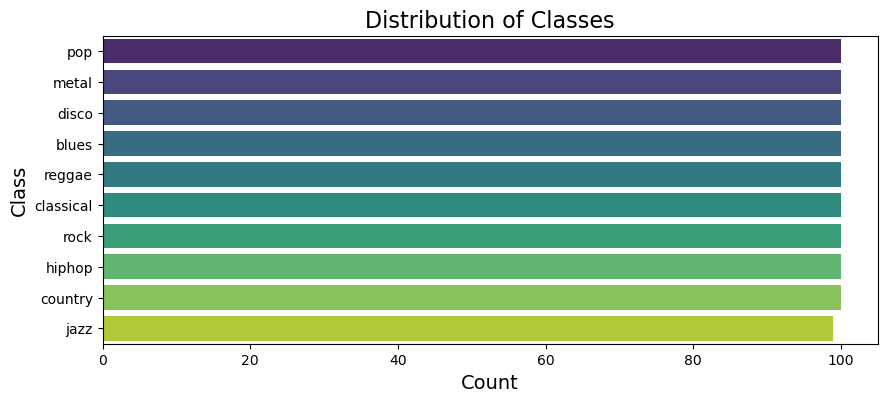

In [34]:
# Plotting count distribution of classes
plt.figure(figsize = (10, 4))
sns.countplot(y = data['Class'], palette = 'viridis')
plt.title('Distribution of Classes', fontsize = 16)
plt.xlabel('Count', fontsize = 14)
plt.ylabel('Class', fontsize = 14)
plt.show()

In [35]:
# Padding or truncating the arrays to a fixed length
x = data['Features'].tolist()
x = pad_sequences(x, dtype = 'float32', padding = 'post', truncating = 'post')
x.shape

(999, 43, 128)

In [36]:
# Encoding class labels
encoder = LabelEncoder()
y = encoder.fit_transform(data['Class'])
y = to_categorical(y)

#### Splitting the Dataset

In [37]:
# Train-validation split
trainX, testX, trainY, testY = train_test_split(x, y, random_state = 0)

In [38]:
print(trainX.shape)
print(testX.shape)
print(trainY.shape)
print(testY.shape)

(749, 43, 128)
(250, 43, 128)
(749, 10)
(250, 10)


#### LSTM Model

In [41]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Define LSTM model architecture
def create_lstm_model(input_shape, num_classes):
    model = Sequential([
        LSTM(128, input_shape=input_shape),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Reshape trainX and testX if necessary
trainX = trainX.reshape(trainX.shape[0], trainX.shape[1], trainX.shape[2])  # No need to reshape, assuming trainX is already in the correct shape
testX = testX.reshape(testX.shape[0], testX.shape[1], testX.shape[2])  # No need to reshape, assuming testX is already in the correct shape

# Compile the model
lstm_model = create_lstm_model(input_shape=(trainX.shape[1], trainX.shape[2]), num_classes=trainY.shape[1])
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
lstm_model.fit(trainX, trainY, epochs=20, batch_size=32)

# Evaluate the model on the test set
loss, accuracy = lstm_model.evaluate(testX, testY)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3473 - loss: 1.8610
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6457 - loss: 1.0103
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7738 - loss: 0.7071
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8204 - loss: 0.5694
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8194 - loss: 0.5185
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8567 - loss: 0.4265
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8658 - loss: 0.4024
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8516 - loss: 0.4540
Epoch 9/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8663 - loss: 0.3975
Epoch 10/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8616 - loss: 0.4133
Epoch 11/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8846 - loss: 0.3627
Epoch 12/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy:

#### CNN Model

In [42]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define CNN model architecture
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Reshape trainX and testX to fit CNN model input shape
trainX_cnn = trainX.reshape(trainX.shape[0], trainX.shape[1], trainX.shape[2], 1)  # Add channel dimension
testX_cnn = testX.reshape(testX.shape[0], testX.shape[1], testX.shape[2], 1)  # Add channel dimension

# Compile the CNN model
cnn_model = create_cnn_model(input_shape=(trainX_cnn.shape[1], trainX_cnn.shape[2], 1), num_classes=trainY.shape[1])
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the CNN model
cnn_model.fit(trainX_cnn, trainY, epochs=10, batch_size=32)

# Evaluate the CNN model on the test set
loss, accuracy = cnn_model.evaluate(testX_cnn, testY)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.2713 - loss: 2.0883
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.7080 - loss: 0.8811
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.7774 - loss: 0.6788
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8301 - loss: 0.4861
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8605 - loss: 0.4383
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9097 - loss: 0.3130
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9222 - loss: 0.2518
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9192 - loss: 0.2257
Epoch 9/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9751 - loss: 0.1058
Epoch 10/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9785 - loss: 0.0718
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8544 - loss: 0.6145
Test Loss: 0.5951953530311584
Test Accuracy: 0.8399999737739563


#### Transformer Model

In [47]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Conv1D, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam

# Define the Transformer model architecture
def create_transformer_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    # Encoder block
    x = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs)
    x = LayerNormalization()(x)
    x = Dropout(0.1)(x)
    
    # Multi-head self-attention
    x_att = MultiHeadAttention(num_heads=2, key_dim=64)(x, x)
    x_att = Dropout(0.1)(x_att)
    
    # Skip connection and layer normalization
    x = LayerNormalization()(x + x_att)
    
    # Global average pooling
    x = GlobalAveragePooling1D()(x)
    
    # Dense layers for classification
    x = Dense(64, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Reshape trainX if necessary (assuming trainX is already in the correct shape)
# Assuming trainX and trainY are already defined

# Define the input shape and number of classes
input_shape = trainX.shape[1:]
num_classes = trainY.shape[1]

# Create and compile the Transformer model
transformer_model = create_transformer_model(input_shape, num_classes)
transformer_model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Train the Transformer model
transformer_model.fit(trainX, trainY, epochs=20, batch_size=32)

# Evaluate the Transformer model on the test set
# Assuming testX and testY are already defined
loss, accuracy = transformer_model.evaluate(testX, testY)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4385 - loss: 1.7606
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7178 - loss: 0.9015
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7916 - loss: 0.6360
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8539 - loss: 0.4945
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8415 - loss: 0.4568
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8456 - loss: 0.4585
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8669 - loss: 0.3569
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9085 - loss: 0.3027
Epoch 9/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8850 - loss: 0.3238
Epoch 10/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8981 - loss: 0.3133
Epoch 11/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8874 - loss: 0.3013
Epoch 12/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9162 - lo

#### Current results
In this process, I have extracted features using the pre-trained VGGish model and trained the data using LSTM, CNN, and Transformer models. The results are as follows:
i. LSTM Model: Test Accuracy: 0.8320000171661377, training accuracy is 0.8325
ii. CNN Model: Test Accuracy: 0.8399999737739563, training accuracy is 0.8544
iii. Transformer Model: Test Accuracy: 0.8360000252723694, training accuracy is 0.8269
The CNN model has the highest test accuracy of 0.84, followed by the Transformer model with an accuracy of 0.83, and the LSTM model with an accuracy of 0.83. The CNN model has the highest training accuracy of 0.85, followed by the LSTM model with an accuracy of 0.83, and the Transformer model with an accuracy of 0.82. The CNN model is the best model among the three models as of now.
